## Data Scientist Case Study

<p style='text-align: justify;'>
In the MyHammer platform we have one challenge. Often consumers submit the service
request in a wrong serviceId category, mostly they get tempted to choose easy options such
as “Sonstiges” (Others).
For example, an actual painting job gets submitted to “Others” serviceId category.
We have discovered the following issues with the current setup:
    
* jobs are in a wrong category
* tradesmen cannot find the proper job because of the above scenario.

This has a direct impact in revenue because the tradesmen cannot find a relevant job while
searching. 
The task is to build an efficient classifier which can classify the wrong serviceId to a correct one. 
The goal is to help consumers to pick the right category by providing a good suggestion of a
correct serviceId category based on the service request details. </p>




### Structure
* **Import libraries and setup Dataframes**
* **Prepare the Data (preprocessing)**
* **Choose the model**
* **Train the model**
* **Make prediction**
* **Summary of Results** 


### Import Libraries & Setup Data

In [1]:
import pandas as pd
import numpy as np
from numpy import array
from numpy import asarray
from numpy import zeros
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('seaborn-whitegrid')
from imblearn.under_sampling import TomekLinks
import nltk as nltk
from nltk.corpus import stopwords
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.impute import SimpleImputer
import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.preprocessing.sequence import pad_sequences
from keras.layers.core import  Dense
from keras.layers import  LSTM
from keras.models import Model
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate
from sklearn.model_selection import train_test_split


In [2]:
# Import data
df = pd.read_excel("Data.xlsx")


# check the data
df.head(3)
#df_test.shape

,id,title,description,createdAt,endedAt,serviceId,user_description,service_based_form,target_date,reissuedCopyOf,...,stateText,sbf_form_text,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21
0,10870620,Badsanierung 39291 Lostau,"Teilaufgaben: Fliesen verlegen, Heizung instal...",2019-05-12 10:10:45,2019-07-05 20:41:41,405110.0,Badsanierung Wanne Toilette Waschtisch verse...,1,In den n√§chsten 3 Monaten,0,...,active,"Teilaufgaben: Fliesen verlegen, Heizung instal...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10877080,"4 m¬≤ Privatfl√§che pflastern, Unterbau erstel...","Teilaufgaben: Privatfl√§che pflastern, Unterba...",2019-05-12 18:06:15,2019-07-02 21:47:02,104010.0,Durch einen neuen Durchbruch der Au√üenwand wu...,1,Zeitnah,0,...,active,"Teilaufgaben: Privatfl√§che pflastern, Unterba...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10898310,"Dusche nachr√ºsten, Heizk√∂rper tauschen, Wass...",- Dusche nachr√ºsten im Bad (EG) (inkl. Wasser...,2019-05-14 08:13:56,2019-07-07 10:01:03,405120.0,- Dusche nachr√ºsten im Bad (EG) (inkl. Wasser...,0,Zeitnah,0,...,active,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25770 entries, 0 to 25769
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       25770 non-null  int64  
 1   title                    25768 non-null  object 
 2   description              25733 non-null  object 
 3   createdAt                25438 non-null  object 
 4   endedAt                  25438 non-null  object 
 5   serviceId                25438 non-null  object 
 6   user_description         530 non-null    object 
 7   service_based_form       25437 non-null  object 
 8   target_date              25438 non-null  object 
 9   reissuedCopyOf           25437 non-null  object 
 10  tradeClassificationType  25437 non-null  object 
 11  state                    25438 non-null  float64
 12  stateText                25438 non-null  object 
 13  sbf_form_text            24990 non-null  object 
 14  Unnamed: 14           

### Prepare the Data (preprocessing)


1. **Remove unneeded, irrelevant features**

In [4]:
df.drop(df.columns[[14,15,16,17,18,19,20,21]], axis=1, inplace=True)
df.drop(['createdAt','endedAt','id','sbf_form_text'], axis =1, inplace= True)

# check the data
df.head(3)
#df_test.shape

,title,description,serviceId,user_description,service_based_form,target_date,reissuedCopyOf,tradeClassificationType,state,stateText
0,Badsanierung 39291 Lostau,"Teilaufgaben: Fliesen verlegen, Heizung instal...",405110.0,Badsanierung Wanne Toilette Waschtisch verse...,1,In den n√§chsten 3 Monaten,0,1.0,0.0,active
1,"4 m¬≤ Privatfl√§che pflastern, Unterbau erstel...","Teilaufgaben: Privatfl√§che pflastern, Unterba...",104010.0,Durch einen neuen Durchbruch der Au√üenwand wu...,1,Zeitnah,0,4.0,0.0,active
2,"Dusche nachr√ºsten, Heizk√∂rper tauschen, Wass...",- Dusche nachr√ºsten im Bad (EG) (inkl. Wasser...,405120.0,- Dusche nachr√ºsten im Bad (EG) (inkl. Wasser...,0,Zeitnah,0,2.0,0.0,active


In [5]:
# Check how our final data frame looks
print("Rows & Columns: ", df.shape, "\nAll columns if the df: ", df.columns.tolist())

Rows & Columns:  (25770, 10) 
All columns if the df:  ['title', 'description', 'serviceId', 'user_description', 'service_based_form', 'target_date', 'reissuedCopyOf', 'tradeClassificationType', 'state', 'stateText']


2. **Looking deeply in our data to determine data type of each feature**

In [6]:
print("Unique values for service_based_form: ", df.service_based_form.unique())
print("Unique values for reissuedCopyOf: ", df.reissuedCopyOf.unique())
print("Unique values for tradeClassificationType: ", df.tradeClassificationType.unique())
print("Unique values for target_date: ", df.target_date.unique())
print("Unique values for state : ", df.state.unique())
print("Unique values for stateText : ", df.stateText.unique())
print("Unique values for serviceId : ", df.serviceId.unique())

Unique values for service_based_form:  [1 0 nan datetime.datetime(2020, 12, 13, 12, 58, 1)
 datetime.datetime(2020, 11, 29, 14, 51, 14)]
Unique values for reissuedCopyOf:  [0 nan 10200185 10671805 8876504 10379245 11526527 13943333
 'Wunschtermin: 27.11.2020' '105080.0']
Unique values for tradeClassificationType:  ['1.0' '4.0' '2.0' nan 946667 0 'Innerhalb der n√§chsten 30 Tage']
Unique values for target_date:  ['In den n√§chsten 3 Monaten' 'Zeitnah' nan 'In 3 bis 6 Monaten'
 'Innerhalb der n√§chsten 30 Tage' 'In mehr als 6 Monaten'
 'Wunschtermin: 11.06.2020' 'Wunschtermin: 28.06.2020'
 'Wunschtermin: 21.09.2019' 'Wunschtermin: 19.12.2019'
 'Wunschtermin: 15.11.2019' 'Wunschtermin: 29.10.2019'
 'Wunschtermin: 11.10.2019' 'Wunschtermin: 25.01.2020'
 'Wunschtermin: 06.12.2019' 'Wunschtermin: 06.01.2020'
 'Wunschtermin: 13.04.2020' 'Wunschtermin: 24.05.2020'
 'Wunschtermin: 21.03.2020' 'Wunschtermin: 12.11.2020'
 'Wunschtermin: 12.12.2020' 'Wunschtermin: 07.12.2020'
 'Wunschtermin: 18.01

#### We can consider the following feature as categorial ones, since some data pattern are repeating for them
* **service_based_form**: include numerical and datatime data
* **reissuedCopyOf**: include numerical and text data
* **tradeClassificationType**: include numerical and text data
* **tradeClassificationType**: include numerical and text data
* **target_date**: include text data
* **state**: include numerical  data
* **stateText**: include numerical and text data
* **serviceId**: include numerical and text data

#### Converting categorial features to numerical one

* service_based_form
* reissuedCopyOf
* tradeClassificationType
* state
* target_date
* stateText
* serviceId



In [7]:
from sklearn import preprocessing
df['serviceId'] = df['serviceId'].astype('str')
le = preprocessing.LabelEncoder()
df['serviceId'] = le.fit_transform(df.serviceId.values)


df['service_based_form'] = df['service_based_form'].astype('str')
le = preprocessing.LabelEncoder()
df['service_based_form'] = le.fit_transform(df.service_based_form.values)

df['reissuedCopyOf'] = df['reissuedCopyOf'].astype('str')
le = preprocessing.LabelEncoder()
df['reissuedCopyOf'] = le.fit_transform(df.reissuedCopyOf.values)

df['state'] = df['state'].astype('str')
le = preprocessing.LabelEncoder()
df['state'] = le.fit_transform(df.state.values)

df['tradeClassificationType'] = df['tradeClassificationType'].astype('str')
le = preprocessing.LabelEncoder()
df['tradeClassificationType'] = le.fit_transform(df.tradeClassificationType.values)

df['target_date'] = df['target_date'].astype('str')
le = preprocessing.LabelEncoder()
df['target_date'] = le.fit_transform(df.target_date.values)


df['stateText'] = df['stateText'].astype('str')
le = preprocessing.LabelEncoder()
df['stateText'] = le.fit_transform(df.stateText.values)


In [8]:
# check the data
df.head(3)
#df_test.shape


,title,description,serviceId,user_description,service_based_form,target_date,reissuedCopyOf,tradeClassificationType,state,stateText
0,Badsanierung 39291 Lostau,"Teilaufgaben: Fliesen verlegen, Heizung instal...",138,Badsanierung Wanne Toilette Waschtisch verse...,1,4,0,1,0,3
1,"4 m¬≤ Privatfl√§che pflastern, Unterbau erstel...","Teilaufgaben: Privatfl√§che pflastern, Unterba...",26,Durch einen neuen Durchbruch der Au√üenwand wu...,1,162,0,3,0,3
2,"Dusche nachr√ºsten, Heizk√∂rper tauschen, Wass...",- Dusche nachr√ºsten im Bad (EG) (inkl. Wasser...,139,- Dusche nachr√ºsten im Bad (EG) (inkl. Wasser...,0,162,0,2,0,3


3. **Checking missing values in dataset**


In [9]:
# Check where we find NaN values

tab_info = pd.DataFrame(df.dtypes).T.rename(index={0:'column Type'}) 
tab_info = tab_info.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info = tab_info.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100).T.
                                       rename(index={0: 'null values (%)'}))
tab_info

,title,description,serviceId,user_description,service_based_form,target_date,reissuedCopyOf,tradeClassificationType,state,stateText
column Type,object,object,int64,object,int64,int64,int64,int64,int64,int64
null values (nb),2,37,0,25240,0,0,0,0,0,0
null values (%),0.00776096,0.143578,0,97.9433,0,0,0,0,0,0


In [10]:
df.isnull().sum()

title                          2
description                   37
serviceId                      0
user_description           25240
service_based_form             0
target_date                    0
reissuedCopyOf                 0
tradeClassificationType        0
state                          0
stateText                      0
dtype: int64

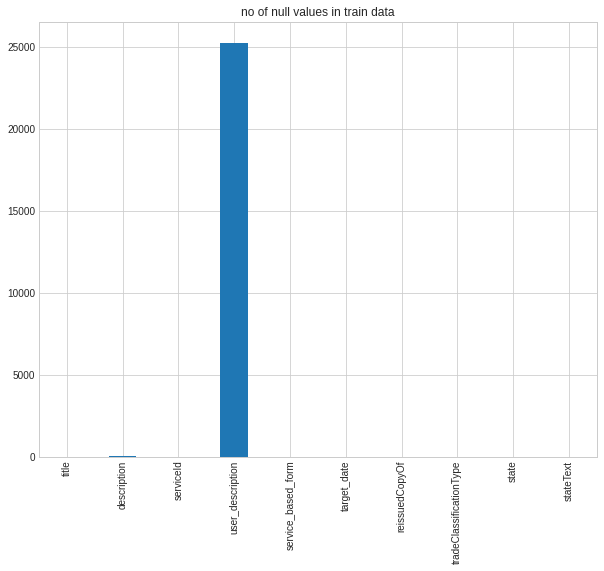

In [11]:
df.isna().sum().plot(kind="bar",figsize=(10, 8))
plt.title("no of null values in train data")
plt.show()



#### Imputing missing values
* drop col **user_description** due to having more that 70\% missing values
* col **title** only has two missing values so we remove these two rows
* imputing categorical features & numerical values with more frequency values in feature
* imputing text features with constant text **nothing**

In [12]:
df.drop(['user_description'], axis=1, inplace=True)

imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
df["serviceId"] = imp.fit_transform(df[["serviceId"]])
df["service_based_form"] = imp.fit_transform(df[["service_based_form"]])
df["target_date"] = imp.fit_transform(df[["target_date"]])
df["reissuedCopyOf"] = imp.fit_transform(df[["reissuedCopyOf"]])
df["tradeClassificationType"] = imp.fit_transform(df[["tradeClassificationType"]])
df["state"] = imp.fit_transform(df[["state"]])
df["stateText"] = imp.fit_transform(df[["stateText"]])

imp = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value="nothing")
df["description"] = imp.fit_transform(df[["description"]])


In [13]:
# Check how our final data frame looks
print("Rows & Columns before remove nan value rows: ", df.shape)
df.dropna(inplace=True)
# Check how our final data frame looks
print("Rows & Columns before remove nan value rows: ", df.shape)

Rows & Columns before remove nan value rows:  (25770, 9)
Rows & Columns before remove nan value rows:  (25768, 9)


In [14]:
# check the data
df.tail(3)
#df_test.shape

,title,description,serviceId,service_based_form,target_date,reissuedCopyOf,tradeClassificationType,state,stateText
25767,Glaswand f√ºr Dusche ohne Haltestange,Ich h√§tte gerne eine Glaswand 1 m breit und ...,160,1,6,0,2,0,3
25768,Birken f√§llen in 14621 Sch√∂nwalde-Glien,Teilaufgaben: Baum f√§llen Anzahl B√§ume: +5 A...,44,1,162,0,3,0,3
25769,80 m¬≤ PVC-Boden verlegen + Material vorhanden...,Teilaufgaben: PVC-Boden verlegen Geb√§udeart: ...,103,1,28,0,2,0,3


#### 4- **Checking for outliers in data**

<AxesSubplot:>

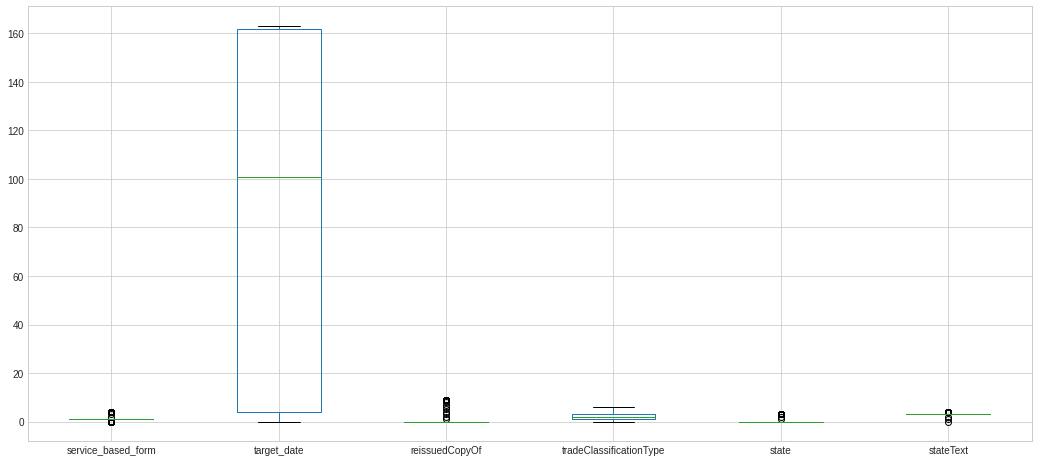

In [15]:
df.plot(x = 'serviceId', kind = 'box',figsize=(18, 8))

From box-plot it is clear we have outliers in serveral features. We need to remove these outliers as it affect the accuracy of the result. 

**Removing outliers from all columens in Data**

In [16]:
from scipy import stats

def drop_numerical_outliers(df, z_thresh=3):
    # Constrains will contain `True` or `False` depending on if it is a value below the threshold.
    constrains = df.select_dtypes(include=[np.number]).apply(lambda x: np.abs(stats.zscore(x)) < z_thresh).all(axis=1)
   # Drop (inplace) values set to be rejected
    df.drop(df.index[~constrains], inplace=True)
drop_numerical_outliers(df)

5. **Checking distribution of features**

We need to check distribution of the numberical features and remove the one that has 

<Figure size 432x288 with 0 Axes>

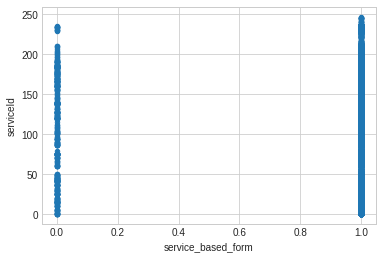

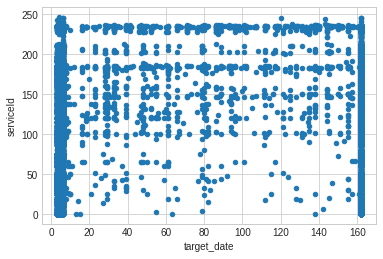

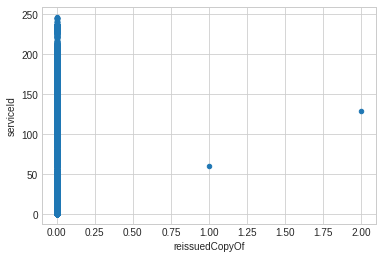

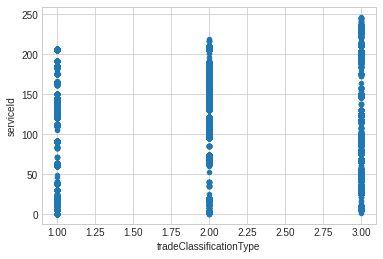

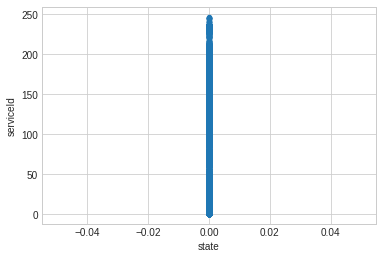

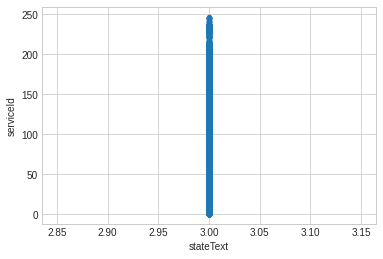

In [17]:
fig = plt.figure()

df.plot.scatter(x = 'service_based_form', y = 'serviceId')


df.plot.scatter(x = 'target_date', y = 'serviceId')


df.plot.scatter(x = 'reissuedCopyOf', y = 'serviceId')


df.plot.scatter(x = 'tradeClassificationType', y = 'serviceId')


df.plot.scatter(x = 'state', y = 'serviceId')


df.plot.scatter(x = 'stateText', y = 'serviceId')

plt.show()

From above scatter plot we can see the below features does have a static distirbution, in other words, all of data points just take one value for them. These features cannot help us in classification models so we remove them.

* StateTest
* State
* reissuedCopyOf


6. **Checking Target feature to know if we have a balanced classification problem**

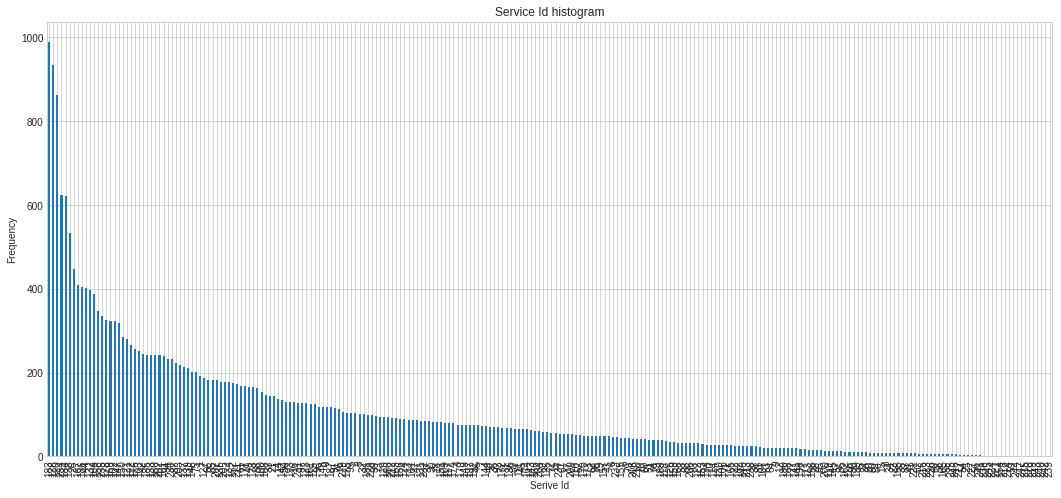

In [18]:
pd.value_counts(df['serviceId']).plot.bar(figsize=(18, 8))
plt.title('Service Id histogram')
plt.xlabel('Serive Id')
plt.ylabel('Frequency')
df['serviceId'].value_counts()
plt.show()

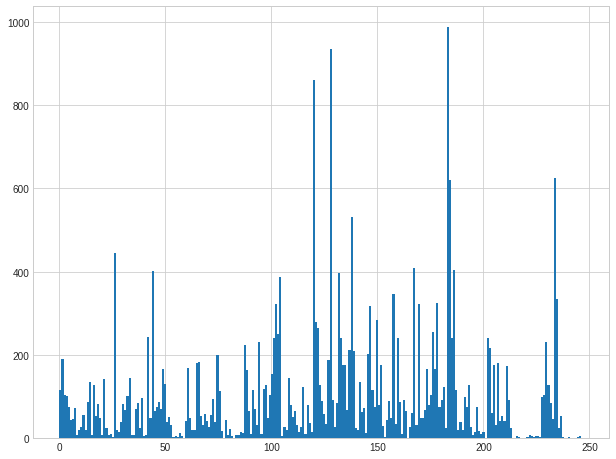

In [19]:
# plot of traget values
df['serviceId'] = df['serviceId'].astype(float)
fig=plt.figure(figsize=(8,6))
his=fig.add_axes([0,0,1,1])
plt.hist(df['serviceId'], bins = 250)
plt.show()

### Challenge:

It seems we have an imbalanced classification problem. As it is clear in above plot, some classes have much more number of data than others. In other words, the distribution of examples across the classes is not equal.

**Proposed solution**

We over-sampling data to have more data points for miniority classes.


In [20]:
from imblearn.over_sampling import RandomOverSampler
# define dataset
X = df[['service_based_form', 'target_date','tradeClassificationType','title']].values
y = df['serviceId']

oversample = RandomOverSampler(sampling_strategy='minority')
# fit and apply the transform
X_over, y_over = oversample.fit_resample(X, y)

In [21]:
df_over = pd.DataFrame(data=np.column_stack((X_over,y_over)),columns=['service_based_form','target_date','tradeClassificationType','title','serviceId'])
df_over.head(3)

,service_based_form,target_date,tradeClassificationType,title,serviceId
0,1,4,1,Badsanierung 39291 Lostau,138
1,1,162,3,"4 m¬≤ Privatfl√§che pflastern, Unterbau erstel...",26
2,0,162,2,"Dusche nachr√ºsten, Heizk√∂rper tauschen, Wass...",139


7. **Cleaning textual features**

#### Cleaning text (nlp) features
* **Remove all irrelevant characters such as any non alphanumeric characters**
* **Tokenize your text by separating it into individual words**
* **Remove stop words- stopwords are those german words which do not add much meaning to a sentence.They are very commonly used words and we do not required those words. So we can remove those stopwords**

In [22]:
# Remove irrelevant characters

df_over['title'] = df_over['title'].astype('str')
#df_over['description'] = df_over['description'].astype('str')
remove_characters = ["->", "≤", "¬" ,"¥" ,"  ","º", "√","§", "¬≤", "∂", "(" ,')', '*', '+','[', '?', '<','>','/','-',',','.',':','1','2','3','4','5','6','7','8','9','0']
for chr in remove_characters:
    
    #df_over.description = df_over.description.str.replace(chr, '', regex=True)
    df_over.title = df_over.title.str.replace(chr, '', regex=True)

# check the data
df_over.head(3)
#df_test.shape

,service_based_form,target_date,tradeClassificationType,title,serviceId
0,1,4,1,Badsanierung Lostau,138
1,1,162,3,m Privatflche pflastern Unterbau erstellen Ma...,26
2,0,162,2,Dusche nachrsten Heizkrper tauschen WasserAbwa...,139


In [23]:
# Tokenize the text
tokenizer=nltk.tokenize.RegexpTokenizer(r'\w+')

#df_over['description'] = df_over['description'].apply(lambda x:tokenizer.tokenize(x))
df_over['title'] = df_over['title'].apply(lambda x:tokenizer.tokenize(x))

# check the data
df_over.head(3)
#df_test.shape

,service_based_form,target_date,tradeClassificationType,title,serviceId
0,1,4,1,"[Badsanierung, Lostau]",138
1,1,162,3,"[m, Privatflche, pflastern, Unterbau, erstelle...",26
2,0,162,2,"[Dusche, nachrsten, Heizkrper, tauschen, Wasse...",139


In [24]:
len(stopwords.words('german'))


232

In [25]:
#Remove stop words
def remove_stopwords(text):
    words = [w for w in text if w not in stopwords.words('german')]
    return words
df_over['title'] = df_over['title'].apply(lambda x : remove_stopwords(x))
#df['description'] = df['description'].apply(lambda x : remove_stopwords(x))

# check the data
df_over.head(3)
#df_test.shape

,service_based_form,target_date,tradeClassificationType,title,serviceId
0,1,4,1,"[Badsanierung, Lostau]",138
1,1,162,3,"[m, Privatflche, pflastern, Unterbau, erstelle...",26
2,0,162,2,"[Dusche, nachrsten, Heizkrper, tauschen, Wasse...",139


In [26]:
def combine_text(list_of_text):
    '''Takes a list of text and combines them into one large chunk of text.'''
    combined_text = ' '.join(list_of_text)
    return combined_text

df_over['title'] = df_over['title'].apply(lambda x : combine_text(x))
#df_over['description'] = df_over['description'].apply(lambda x : combine_text(x))


# check the data
df_over.head(3)
#df_test.shape

,service_based_form,target_date,tradeClassificationType,title,serviceId
0,1,4,1,Badsanierung Lostau,138
1,1,162,3,m Privatflche pflastern Unterbau erstellen Mat...,26
2,0,162,2,Dusche nachrsten Heizkrper tauschen WasserAbwa...,139


### Choose the model

Here we have a mixture of numerical and text features. We would like to use the information in both of them. In other words, we have a Multi-Data-Type Classification including both numerical and textual information. We suggest two models for implementing the classification:

 **Multi-Date Type classification with Keras**
<p style='text-align: justify;'>
Creating a deep learning model in Keras that is capable of accepting multiple inputs, concatenating the two outputs and then performing classification using the aggregated input.
  
In this model, we created two submodeles. The first submodel will accept textual input from "title" features (to avoid complexity, we do not consider other textual features) in the form of text data. This submodel will consist of an input shape layer, an embedding layer, and an LSTM layer of 300 neurons. The second submodel will accept input in the form of meta information from the numerical columns. The second submodel also consist of three layers. An input layer and two dense layers.

The output from the LSTM layers of the first submodel and the output from the dense layer of the second submodel will be concatenated together and will be used as concatenated input to another dense layer with 10 neurons. Finally, the output dense layer will have 250 neuorns corresponding to each serviceId. </p>
  
 


In [56]:
X = df_over.drop(['serviceId'], axis=1)

y = df_over['serviceId']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [57]:
X1_train = []
sentences = list(X_train["title"])
for sen in sentences:
    X1_train.append(sen)

X1_test = []
sentences = list(X_test["title"])
for sen in sentences:
    X1_test.append(sen)
 

In [58]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X1_train)

X1_train = tokenizer.texts_to_sequences(X1_train)
X1_test = tokenizer.texts_to_sequences(X1_test)


vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X1_train = pad_sequences(X1_train, padding='post', maxlen=maxlen)
X1_test = pad_sequences(X1_test, padding='post', maxlen=maxlen)


In [30]:
embeddings_dictionary = dict()

glove_file = open('glove.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions

glove_file.close()

embedding_matrix = zeros((vocab_size, 300))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [59]:
X2_train = X_train[[ 'service_based_form', 'target_date','tradeClassificationType']].values
X2_test = X_test[['service_based_form', 'target_date','tradeClassificationType']].values


In [60]:
X2_train = X2_train.astype(int)
X2_test = X2_train.astype(int)
y_train = y_train.astype(int)
y_test = y_test.astype(int)



**Feature scaling**

As our numerical features have different scales, we need ot standardize them into the fixed range.

In [33]:
scaler = StandardScaler()
X2_train = scaler.fit_transform(X2_train)
X2_test = scaler.fit_transform(X2_test) 


In [34]:
input_1 = Input(shape=(maxlen,))


input_2 = Input(shape=(3,))

In [35]:
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], trainable=False)(input_1)

LSTM_Layer_1 = LSTM(300)(embedding_layer)


dense_layer_1 = Dense(300, activation='relu')(input_2)
dense_layer_2 = Dense(300, activation='relu')(dense_layer_1)

concat_layer = Concatenate()([LSTM_Layer_1, dense_layer_2])
dense_layer_3 = Dense(300, activation='relu')(concat_layer)
output = Dense(250, activation='softmax')(dense_layer_3)
model = Model(inputs=[input_1, input_2], outputs=output)


model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam',  metrics=['acc'])


In [64]:
history = model.fit(x=[X1_train, X2_train], y=y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)


Epoch 1/10
133/133 [==============================] - 399s 3s/step - loss: 8.1389 - acc: 0.0818 - val_loss: 4.3249 - val_acc: 0.0939
Epoch 2/10
133/133 [==============================] - 412s 3s/step - loss: 3.9492 - acc: 0.1204 - val_loss: 3.8482 - val_acc: 0.1396
Epoch 3/10
133/133 [==============================] - 417s 3s/step - loss: 3.7931 - acc: 0.1281 - val_loss: 3.9206 - val_acc: 0.1318
Epoch 4/10
133/133 [==============================] - 407s 3s/step - loss: 3.8169 - acc: 0.1274 - val_loss: 3.8008 - val_acc: 0.1389
Epoch 5/10
133/133 [==============================] - 412s 3s/step - loss: 3.7630 - acc: 0.1295 - val_loss: 3.8154 - val_acc: 0.1313
Epoch 6/10
133/133 [==============================] - 406s 3s/step - loss: 3.7527 - acc: 0.1310 - val_loss: 3.7936 - val_acc: 0.1389
Epoch 7/10
133/133 [==============================] - 405s 3s/step - loss: 3.7439 - acc: 0.1302 - val_loss: 3.7783 - val_acc: 0.1372
Epoch 8/10
133/133 [==============================] - 406s 3s/step - 

### Make the prediction

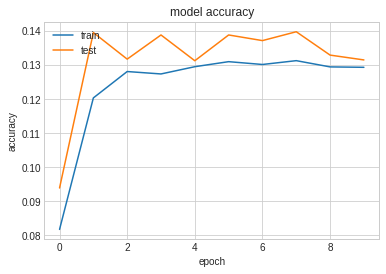

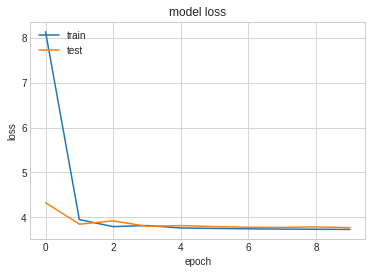

In [66]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

## Summarising Results 


We do not get the good accuracy in prediction results. There maybe some reasons for it:
* For huge complexity, we had to run just for 10 iterations. It is possible that accuracy will be increased as the number of iterations increase.
* We just consider one textual feature in generating our model, still there is a probability that with making more complex our network with having other textual features, we can increase the accuracy.
* As we have 250 different classes, and we do not have a balanced dataset, make increasing the number of sample data points can help to a better accuracy